# 1. Data Preprocessing & Cleaning


In [1]:
import pandas as pd
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/ai ml/week8/trum_tweet_sentiment_analysis.csv')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


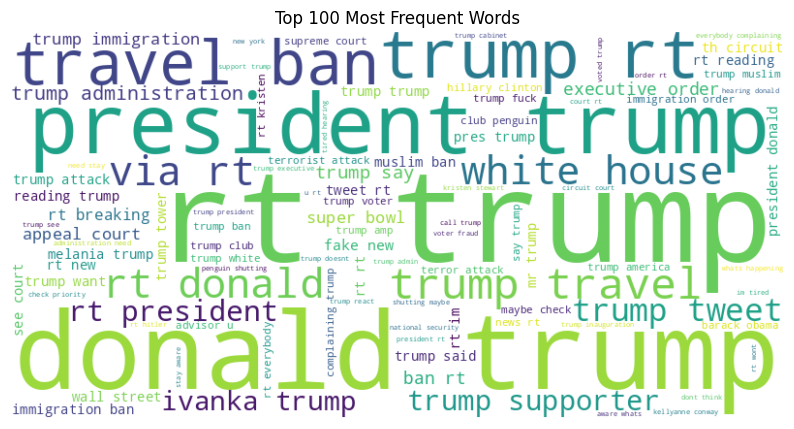

In [ ]:
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# Rename columns if needed
df.columns = df.columns.str.lower()

# Clean text function
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r"@\w+|#", '', text)
    text = re.sub(r"[^\w\s]", '', text)
    text = re.sub(r"\d+", '', text)
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)


df['cleaned_text'] = df['text'].apply(preprocess_text)

all_words = ' '.join(df['cleaned_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(all_words)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top 100 Most Frequent Words')
plt.show()


# 2. Tokenization & Padding


In [ ]:
print(df.columns)
df = df.dropna(subset=['sentiment'])

Index(['text', 'sentiment', 'cleaned_text'], dtype='object')


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Split into train/test before tokenization (important to prevent data leakage)
X = df['cleaned_text']
Y = df['sentiment']  # or df['Sentiment'] if original column name was capitalized

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

# Tokenizer (fit only on training data)
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# Convert to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Calculate padding length using 95th percentile
seq_lengths = [len(seq) for seq in X_train_seq]
max_len = int(np.percentile(seq_lengths, 95))

# Apply padding
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

print("Max length (95th percentile):", max_len)
print("X_train_pad shape:", X_train_pad.shape)
print("X_test_pad shape:", X_test_pad.shape)


Max length (95th percentile): 16
X_train_pad shape: (801164, 16)
X_test_pad shape: (200291, 16)


# 3. Model Building
Implement two models:

1. Simple RNN

2. LSTM

Each model should include:

• Embedding Layer (input dim=vocab size, output dim=128)

• Recurrent Layer (SimpleRNN or LSTM with 64 units)

• Dense Layer (sigmoid activation for binary classification)

# Shared Configuration:

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense

# Vocabulary size and other common settings
vocab_size = 10000
embedding_dim = 128
input_length = X_train_pad.shape[1]  # Max length from padding


# Simple RNN Model

In [ ]:
# Build Simple RNN model
rnn_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length),
    SimpleRNN(64),
    Dense(1, activation='sigmoid')  # Binary classification
])

rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
rnn_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# LSTM Model

In [ ]:
# Build LSTM model
lstm_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length),
    LSTM(64),
    Dense(1, activation='sigmoid')  # Binary classification
])

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# Training & Evaluation
• Compile models with:


– Optimizer: adam

– Metrics: accuracy

• Train for 10 epochs with early stopping.

• Evaluate using:



– Accuracy

– Confusion Matrix

– Classification Report (Precision, Recall, F1-Score)

# Early Stopping

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)


# Train and Evaluate: Simple RNN

In [ ]:
# Train the RNN model
history_rnn = rnn_model.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=5,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np

# Predict and round for binary classification
y_pred_rnn = (rnn_model.predict(X_test_pad) > 0.5).astype("int32")

# Print evaluation metrics
print(" RNN Model Evaluation")
print("Accuracy:", accuracy_score(y_test, y_pred_rnn))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rnn))
print("Classification Report:\n", classification_report(y_test, y_pred_rnn))


Epoch 1/5
10015/10015 ━━━━━━━━━━━━━━━━━━━━ 156s 15ms/step - accuracy: 0.9063 - loss: 0.2288 - val_accuracy: 0.9530 - val_loss: 0.1296
Epoch 2/5
10015/10015 ━━━━━━━━━━━━━━━━━━━━ 188s 14ms/step - accuracy: 0.9627 - loss: 0.1032 - val_accuracy: 0.9586 - val_loss: 0.1160
Epoch 3/5
10015/10015 ━━━━━━━━━━━━━━━━━━━━ 147s 14ms/step - accuracy: 0.9725 - loss: 0.0791 - val_accuracy: 0.9616 - val_loss: 0.1171
Epoch 4/5
10015/10015 ━━━━━━━━━━━━━━━━━━━━ 200s 14ms/step - accuracy: 0.9774 - loss: 0.0651 - val_accuracy: 0.9593 - val_loss: 0.1247
Epoch 5/5
10015/10015 ━━━━━━━━━━━━━━━━━━━━ 201s 14ms/step - accuracy: 0.9811 - loss: 0.0556 - val_accuracy: 0.9610 - val_loss: 0.1164
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.
6260/6260 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
 RNN Model Evaluation
Accuracy: 0.9585802657133871
Confusion Matrix:
 [[132608   3742]
 [  4554  59387]]
Classification Report:
               precision    recall  f1-score   support

         0.0       

# Train and Evaluate: LSTM

In [ ]:
# Train the LSTM model
history_lstm = lstm_model.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=5,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

# Predict and round
y_pred_lstm = (lstm_model.predict(X_test_pad) > 0.5).astype("int32")

# Print evaluation metrics
print("LSTM Model Evaluation")
print("Accuracy:", accuracy_score(y_test, y_pred_lstm))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lstm))
print("Classification Report:\n", classification_report(y_test, y_pred_lstm))


Epoch 1/5
10015/10015 ━━━━━━━━━━━━━━━━━━━━ 275s 27ms/step - accuracy: 0.9111 - loss: 0.2167 - val_accuracy: 0.9594 - val_loss: 0.1120
Epoch 2/5
10015/10015 ━━━━━━━━━━━━━━━━━━━━ 263s 26ms/step - accuracy: 0.9653 - loss: 0.0963 - val_accuracy: 0.9662 - val_loss: 0.0976
Epoch 3/5
10015/10015 ━━━━━━━━━━━━━━━━━━━━ 322s 26ms/step - accuracy: 0.9748 - loss: 0.0703 - val_accuracy: 0.9678 - val_loss: 0.0944
Epoch 4/5
10015/10015 ━━━━━━━━━━━━━━━━━━━━ 324s 26ms/step - accuracy: 0.9816 - loss: 0.0530 - val_accuracy: 0.9700 - val_loss: 0.0974
Epoch 5/5
10015/10015 ━━━━━━━━━━━━━━━━━━━━ 262s 26ms/step - accuracy: 0.9860 - loss: 0.0400 - val_accuracy: 0.9689 - val_loss: 0.1001
Restoring model weights from the end of the best epoch: 3.
6260/6260 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step
LSTM Model Evaluation
Accuracy: 0.9680764487670439
Confusion Matrix:
 [[133759   2591]
 [  3803  60138]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.98      0.98

# Visualization
• Plot training vs. validation loss & accuracy over epochs.
• Compare RNN vs. LSTM performance.

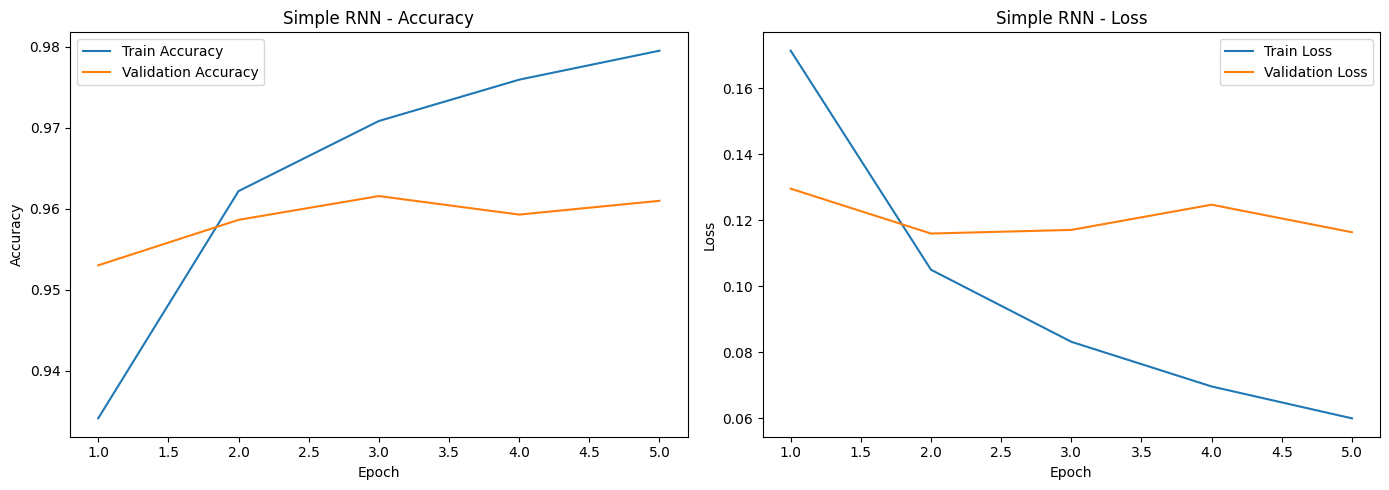

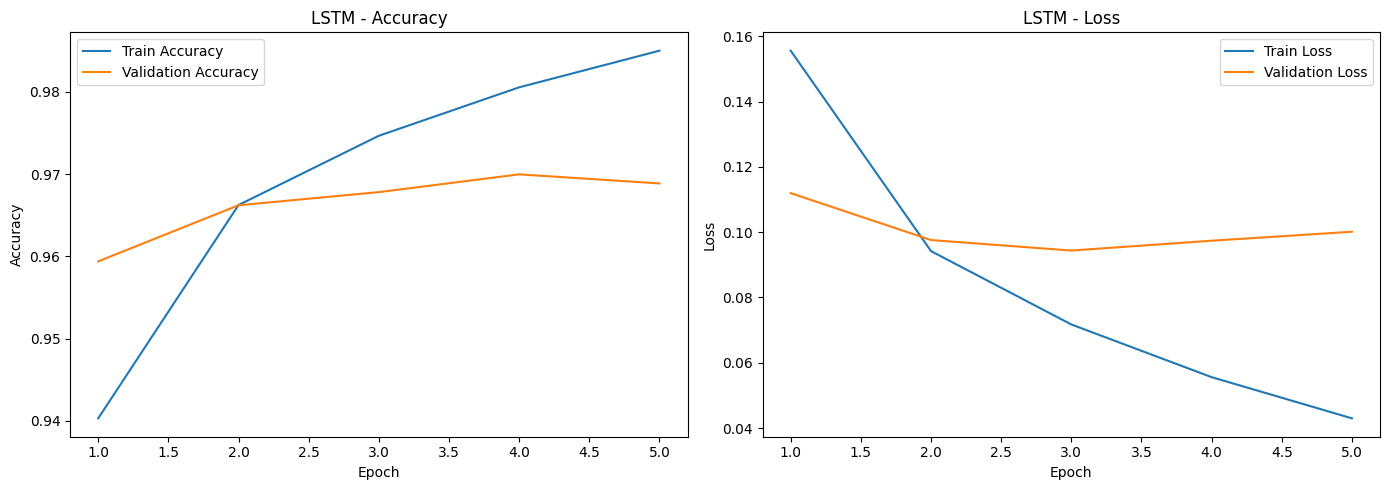

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history, title='Model'):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot for RNN
plot_history(history_rnn, title='Simple RNN')

# Plot for LSTM
plot_history(history_lstm, title='LSTM')


# Streamlit GUI

In [ ]:
!pip install gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.6/322.6 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 104.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.6 MB/s eta 0:00:00


In [ ]:
import gradio as gr
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Preprocessing function (same as earlier)
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_input(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r"@\w+|#", '', text)
    text = re.sub(r"[^\w\s]", '', text)
    text = re.sub(r"\d+", '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

# Prediction function
def predict_sentiment(tweet):
    cleaned = preprocess_input(tweet)
    seq = tokenizer.texts_to_sequences([cleaned])
    padded = pad_sequences(seq, maxlen=X_train_pad.shape[1], padding='post', truncating='post')
    prediction = lstm_model.predict(padded)[0][0]
    sentiment = "😊 Positive" if prediction > 0.5 else "☹️ Negative"
    return f"{sentiment} ({prediction:.2f})"

# Gradio interface
interface = gr.Interface(fn=predict_sentiment,
                         inputs="text",
                         outputs="text",
                         title="Twitter Sentiment Predictor",
                         description="Enter a tweet to classify it as positive or negative using LSTM.")

interface.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c68efd96f7e67041fd.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
